In [257]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [282]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import pandas as pd
import datetime as dt

In [283]:
# 한글 깨짐 현상을 해결
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [284]:
with open('../../BIGCON_DATA_ver1.2/SK_DATA.bin', 'rb') as f:
    sk_data = pickle.load(f) 
with open('../../BIGCON_DATA_ver1.2/SH_DATA.bin', 'rb') as f:
    sh_data = pickle.load(f) 
    
# sk 데이터
sk_age = sk_data['SK_AGE']
sk_time = sk_data['SK_TIME']

# sh 데이터
sh_resident = sh_data['SH_RESIDENT']
sh_foreign = sh_data['SH_FOREIGN']

### 수식
* 식 : 1 - (위해지표+취약지표-경감지표)
    * 위해지표 = 감염병 확진자수
    * 취약지표 = 고령인구수 -> 나이가 많은 사람이 코로나에 더 취약함
    * 경감지표 = 의료기관 수 
    
    
* 흐름도
    1. 서울/대구 지역별 확진자 수 데이터 구하기 (일별 데이터 가능) (O)
    2. 서울/대구 지역별 고령 인구수 데이터 구하기 (월별 데이터) (O)
    3. 서울/대구 지역별 의료기관 수 구하기 (음.. 일별 데이터 애매....)
    4. ①과 ②,③의 값을  -> 0~1으로 만들기
    5. 100 - (① + ② - ③) 하기
   
   
* 데이터 info
    * [전체 확진자 수](https://news.google.com/covid19/map?hl=ko&mid=%2Fm%2F06qd3&gl=KR&ceid=KR%3Ako) => all_covid.xlsx
    * [대구 확진자 수](http://covid19.daegu.go.kr/00936642.html#LINK) => daegu_covid_num.xlsx
    * [서울 확진자 수](http://data.seoul.go.kr/dataList/OA-20279/S/1/datasetView.do) => seoul_covid_num.xlsx
    * [고령 인구 수](http://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1YL20631) => old_people.csv
    * [지역별 의료기관 수](https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043078) => covid_hosp_service.csv
        

 ## 목차
 
 * [1.서울/대구/전체 확진자 수 구하기](#1.-서울/대구/전체-확진자-수-구하기)
 * [2.서울/대구/전체 고령인구수 구하기](#2.-서울/대구/전체-고령인구수-구하기)
 * [3.서울/대구/전체 지역별 의료기관 수](#3.-서울/대구/전체-지역별-의료기관-수)
 * [4.위의 값을 붙여준다 (확진자수+고령인구수+의료기관수)](#4.위의-값을-붙여준다-(확진자수+고령인구수+의료기관수))
 * [5.MinMaxScaler를 사용해 값을 0과 1사이로 만들어준다.](#5.-MinMaxScaler를-사용해-값을-0과-1사이로-만들어준다.)
 * [6.수식에 따라 계산한다. 수식 : 1-(위해지표+취약지표-경감지표)](#6.-수식에-따라-계산한다.-수식-:-1---(위해지표+취약지표-경감지표))
 * [7.sk유동인구와 sh매출액을 서울/대구/(서울+대구) 쪼갠 후 월별로-합하기](#7.-sk유동인구와-sh매출액을-서울/대구/(서울+대구)-쪼갠-후-월별로-합하기)
 * [8.지표와 상관관계 그려보기](#8.-지표와-상관관계-그려보기)

In [102]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

### 1. 서울/대구/전체 확진자 수 구하기

In [331]:
# 위해 지표 데이터(가충지 50%)
all_num = pd.read_excel('../covid_dataset/all_covid.xlsx')
seoul_num = pd.read_excel('../covid_dataset/seoul_covid_num.xlsx')
daegu_num = pd.read_excel('../covid_dataset/daegu_covid_num.xlsx')

In [337]:
# 월컬럼 추가하기
all_num['MONTH'] = all_num['DATE'].dt.month
seoul_num['MONTH'] =  seoul_num['DATE'].dt.month
daegu_num['MONTH'] =  daegu_num['DATE'].dt.month

In [338]:
# 월별로 확진자수 합하기
all_month_num = pd.DataFrame(all_num.groupby('MONTH')['NUM'].sum())
all_month_num.reset_index(level=['MONTH'], inplace = True)

seoul_month_num = pd.DataFrame(seoul_num.groupby('MONTH')['NUM'].sum())
seoul_month_num.reset_index(level=['MONTH'], inplace = True)

daegu_month_num = pd.DataFrame(daegu_num.groupby('MONTH')['NUM'].sum())
daegu_month_num.reset_index(level=['MONTH'], inplace = True)

In [339]:
all_month_num

,MONTH,NUM
0,2,3138
1,3,6737
2,4,887
3,5,729


In [145]:
seoul_month_num

,MONTH,NUM
0,2,80
1,3,391
2,4,156
3,5,228


In [146]:
daegu_month_num

,MONTH,NUM
0,2,2055
1,3,4628
2,4,168
3,5,31


### 2. 서울/대구/전체 고령인구수 구하기
* https://www.data.go.kr/data/15062229/fileData.do => 국토교통부제공 사용 X
* http://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1YL20631 => 통계청 사용 O / 구별로 볼수 있음, 2019년2020년 2,3,4,5월(O)  => 일별 X

In [353]:
old_num = pd.read_csv('../covid_dataset/old_people.csv', encoding='cp949')
old_num = old_num.drop(0)
old_num

,행정구역별(1),행정구역별(2),2019. 02,2019. 03,2019. 04,2019. 05,2020. 02,2020. 03,2020. 04,2020. 05
1,전국,소계,7710310,7748488,7773471,7804999,8122592,8193267,8229428,8265848
2,서울특별시,소계,1421956,1429163,1433709,1439124,1497449,1510460,1516443,1522550
3,서울특별시,중구,22023,22120,22232,22321,23257,23448,23525,23620
4,서울특별시,노원구,77688,78094,78341,78637,81919,82605,82973,83310
5,대구광역시,소계,366000,367661,368800,370113,383965,387318,388845,390430
6,대구광역시,중구,15615,15628,15601,15546,15657,15733,15723,15721
7,대구광역시,수성구,61576,61798,62015,62246,64313,64829,65011,65173


In [354]:
# 데이터 형식 바꾸기
old_num['행정구역별(2)'] = old_num['행정구역별(2)'].str.replace('소계', '')
col_names = old_num['행정구역별(1)']+old_num['행정구역별(2)']
col_names = col_names.tolist()

old_num = old_num.T
old_num = old_num.drop(['행정구역별(1)','행정구역별(2)'])
old_num.columns = col_names

old_num = old_num.rename_axis('DATE').reset_index()

# 월컬럼 추가하기
old_num['MONTH'] = old_num['DATE'].str.split('.',expand=True)[1].str.replace('0','')
old_num

,DATE,전국,서울특별시,서울특별시중구,서울특별시노원구,대구광역시,대구광역시중구,대구광역시수성구,MONTH
0,2019. 02,7710310,1421956,22023,77688,366000,15615,61576,2
1,2019. 03,7748488,1429163,22120,78094,367661,15628,61798,3
2,2019. 04,7773471,1433709,22232,78341,368800,15601,62015,4
3,2019. 05,7804999,1439124,22321,78637,370113,15546,62246,5
4,2020. 02,8122592,1497449,23257,81919,383965,15657,64313,2
5,2020. 03,8193267,1510460,23448,82605,387318,15733,64829,3
6,2020. 04,8229428,1516443,23525,82973,388845,15723,65011,4
7,2020. 05,8265848,1522550,23620,83310,390430,15721,65173,5


In [355]:
old_2020_all = old_num.iloc[4:8,[1,8]]
old_2020_seoul = old_num.iloc[4:8,[2,3,4,8]]
old_2020_daegu = old_num.iloc[4:8,[5,6,7,8]]

In [356]:
old_2020_all.reset_index(drop=True, inplace=True)
old_2020_all

,전국,MONTH
0,8122592,2
1,8193267,3
2,8229428,4
3,8265848,5


In [357]:
old_2020_seoul.reset_index(drop=True, inplace=True)
old_2020_seoul

,서울특별시,서울특별시중구,서울특별시노원구,MONTH
0,1497449,23257,81919,2
1,1510460,23448,82605,3
2,1516443,23525,82973,4
3,1522550,23620,83310,5


In [358]:
old_2020_daegu.reset_index(drop=True, inplace=True)
old_2020_daegu

,대구광역시,대구광역시중구,대구광역시수성구,MONTH
0,383965,15657,64313,2
1,387318,15733,64829,3
2,388845,15723,65011,4
3,390430,15721,65173,5


### 3. 서울/대구/전체 지역별 의료기관 수 

* score 낼 때 1) 서울/대구 지역에 있는 의료기관만 카운트해서 측정해보기 2) 전국구로 일자별 카운트해서 측정하기

##### 공공데이터 open api

In [ ]:
# from urllib.request import urlopen
# from urllib.parse import urlparse, parse_qs, urlencode, quote_plus,
from urllib.parse import unquote
import urllib
import requests
import json
import pandas as pd
import bs4

In [ ]:
key= unquote('sFIQAV7MF44AWTv8631Q4%2FjazjIR1ep03poSb10%2FH3BLXUbYCQko9tMvdaNT%2Bg3QsokgHw0wbzdmF1xWamBZXw%3D%3D')

In [ ]:
# A0: 국민안심병원
# 97: 코로나검사실시기관
# 99: 코로나 선별진료소 운영기관

url='http://apis.data.go.kr/B551182/pubReliefHospService/getpubReliefHospList'

adtfrdd, sggunm, sidonm, spcladmtycd, telno, yadmnm = [], [], [], [], [], []

for page_num in range(1, 109):
    params={'serviceKey': unquote(key),
                'numOfRows': '10',
                'pageNo': page_num
               }

    response = requests.get(url, params=params)
    soup = bs4.BeautifulSoup(response.text, 'html.parser')

    item_ls = soup.find_all('item')

    for item in item_ls:

        adtfrdd.append(item.find('adtfrdd').text)
        sggunm.append(item.find('sggunm').text)
        sidonm.append(item.find('sidonm').text)
        spcladmtycd.append(item.find('spcladmtycd').text)
        telno.append(item.find('telno').text)
        yadmnm.append(item.find('yadmnm').text)

In [ ]:
covid_hospital = pd.DataFrame({'adtfrdd':adtfrdd,
                             'sggunm':sggunm,
                             'sidonm':sidonm,
                             'spcladmtycd':spcladmtycd,
                             'telno':telno,
                             'yadmnm':yadmnm})
covid_hospital.to_csv('../covid_dataset/covid_hosp_service.csv', index=False)    
covid_hospital

In [159]:
covid_hospital = pd.read_csv('../covid_dataset/covid_hosp_service.csv')
covid_hospital.head()

,adtfrdd,sggunm,sidonm,spcladmtycd,telno,yadmnm
0,20200220,강동구,서울,97,02-517-1728,(의)한국필의료재단 한국의원
1,20200220,광명시,경기,97,-1899-1510,의료법인 신원의료재단 신원의원
2,20200220,관악구,서울,97,02-1877-8875,에이치플러스 양지병원
3,20200220,동작구,서울,97,-1800-1114,중앙대학교병원
4,20200220,부산진구,부산,97,051-890-6114,인제대학교부산백병원


In [195]:
covid_97_99 = covid_hospital.query("spcladmtycd in ['97','99']")
covid_97_99_seoul = covid_97_99.query("sidonm == '서울'")
covid_97_99_daegu = covid_97_99.query("sidonm == '대구'")

In [196]:
# 월 컬럼 추가
covid_97_99_all = covid_97_99
covid_97_99_all['DATE'] = pd.to_datetime(covid_97_99_all['adtfrdd'], format='%Y%m%d')
covid_97_99_all['MONTH'] = covid_97_99_all['DATE'].dt.month 
covid_97_99_all = covid_97_99_all.drop(['adtfrdd'],axis=1)
covid_97_99_all = covid_97_99_all.sort_values(by=['DATE'],axis=0)

# 월 컬럼 추가
covid_97_99_seoul['DATE'] = pd.to_datetime(covid_97_99_seoul['adtfrdd'], format='%Y%m%d')
covid_97_99_seoul['MONTH'] = covid_97_99_seoul['DATE'].dt.month 
covid_97_99_seoul = covid_97_99_seoul.drop(['adtfrdd'],axis=1)
covid_97_99_seoul = covid_97_99_seoul.sort_values(by=['DATE'],axis=0)

# 월 컬럼 추가
covid_97_99_daegu['DATE'] = pd.to_datetime(covid_97_99_daegu['adtfrdd'], format='%Y%m%d')
covid_97_99_daegu['MONTH'] = covid_97_99_daegu['DATE'].dt.month 
covid_97_99_daegu = covid_97_99_daegu.drop(['adtfrdd'],axis=1)
covid_97_99_daegu = covid_97_99_daegu.sort_values(by=['DATE'],axis=0)

In [208]:
# 월별로 확진자수 합하기
month_97_99_all = pd.DataFrame(covid_97_99_all.groupby('MONTH').size().cumsum())
month_97_99_all.reset_index(level=['MONTH'], inplace = True)
month_97_99_all.columns = ['MONTH', 'CNT']

month_97_99_seoul = pd.DataFrame(covid_97_99_seoul.groupby('MONTH').size().cumsum())
month_97_99_seoul.reset_index(level=['MONTH'], inplace = True)
month_97_99_seoul.columns = ['MONTH', 'CNT']

month_97_99_daegu = pd.DataFrame(covid_97_99_daegu.groupby('MONTH').size().cumsum())
month_97_99_daegu.reset_index(level=['MONTH'], inplace = True)
month_97_99_daegu.columns = ['MONTH', 'CNT']

In [363]:
# 필요한 월 : 2,3,4,5  없는 월도 채워주자!
need_month = pd.DataFrame({'MONTH':[2,3,4,5]})

month_all = pd.merge(month_97_99_all, need_month, on='MONTH', how='right').fillna(method='ffill')
month_seoul = pd.merge(month_97_99_seoul, need_month, on='MONTH', how='right').fillna(method='ffill')
month_daegu = pd.merge(month_97_99_daegu, need_month, on='MONTH', how='right').fillna(method='ffill')

In [364]:
month_all

,MONTH,CNT
0,2,740.0
1,3,745.0
2,4,745.0
3,5,754.0


In [365]:
month_seoul

,MONTH,CNT
0,2,104.0
1,3,105.0
2,4,105.0
3,5,108.0


In [366]:
month_daegu

,MONTH,CNT
0,2,30.0
1,3,30.0
2,4,30.0
3,5,30.0


### 4.위의 값을 붙여준다 (확진자수+고령인구수+의료기관수)

In [368]:
month_concat_all = pd.concat([all_month_num, old_2020_all['전국'], month_all['CNT']], axis=1)
month_concat_seoul = pd.concat([seoul_month_num, old_2020_seoul['서울특별시'], month_seoul['CNT']], axis=1)
month_concat_daegu = pd.concat([daegu_month_num, old_2020_daegu['대구광역시'], month_daegu['CNT']], axis=1)

In [371]:
month_concat_all

,MONTH,NUM,전국,CNT
0,2,3138,8122592,740.0
1,3,6737,8193267,745.0
2,4,887,8229428,745.0
3,5,729,8265848,754.0


In [369]:
month_concat_seoul

,MONTH,NUM,서울특별시,CNT
0,2,80,1497449,104.0
1,3,391,1510460,105.0
2,4,156,1516443,105.0
3,5,228,1522550,108.0


In [370]:
month_concat_daegu

,MONTH,NUM,대구광역시,CNT
0,2,2055,383965,30.0
1,3,4628,387318,30.0
2,4,168,388845,30.0
3,5,31,390430,30.0


### 5. MinMaxScaler를 사용해 값을 0과 1사이로 만들어준다.

In [378]:
min_max_scaler = MinMaxScaler()
month_concat_all[['NUM', '전국', 'CNT']] = min_max_scaler.fit_transform(month_concat_all[['NUM', '전국', 'CNT']])

In [379]:
month_concat_all

,MONTH,NUM,전국,CNT,INDEX
0,2,0.400965,0.000000,0.000000,0.699276
1,3,1.000000,0.493348,0.357143,0.215949
2,4,0.026298,0.745770,0.357143,0.883120
3,5,0.000000,1.000000,1.000000,1.000000


In [380]:
min_max_scaler = MinMaxScaler()
month_concat_seoul[['NUM', '서울특별시', 'CNT']] = min_max_scaler.fit_transform(month_concat_seoul[['NUM', '서울특별시', 'CNT']])

In [381]:
month_concat_seoul

,MONTH,NUM,서울특별시,CNT
0,2,0.000000,0.000000,0.00
1,3,1.000000,0.518346,0.25
2,4,0.244373,0.756703,0.25
3,5,0.475884,1.000000,1.00


In [382]:
min_max_scaler = MinMaxScaler()
month_concat_daegu[['NUM', '대구광역시', 'CNT']] = min_max_scaler.fit_transform(month_concat_daegu[['NUM', '대구광역시', 'CNT']])

In [383]:
month_concat_daegu

,MONTH,NUM,대구광역시,CNT
0,2,0.440287,0.000000,0.0
1,3,1.000000,0.518639,0.0
2,4,0.029802,0.754834,0.0
3,5,0.000000,1.000000,0.0


### 6. 수식에 따라 계산한다. 수식 : 1 - (위해지표+취약지표-경감지표)

In [384]:
month_concat_all['INDEX'] = 1 - ((month_concat_all['NUM']*0.75)+(month_concat_all['전국']*0.25)-(month_concat_all['CNT']*0.25))
month_concat_all

,MONTH,NUM,전국,CNT,INDEX
0,2,0.400965,0.000000,0.000000,0.699276
1,3,1.000000,0.493348,0.357143,0.215949
2,4,0.026298,0.745770,0.357143,0.883120
3,5,0.000000,1.000000,1.000000,1.000000


In [385]:
month_concat_seoul['INDEX'] = 1 - ((month_concat_seoul['NUM']*0.75)+(month_concat_seoul['서울특별시']*0.25)-(month_concat_seoul['CNT']*0.25))
month_concat_seoul

,MONTH,NUM,서울특별시,CNT,INDEX
0,2,0.000000,0.000000,0.00,1.000000
1,3,1.000000,0.518346,0.25,0.182914
2,4,0.244373,0.756703,0.25,0.690045
3,5,0.475884,1.000000,1.00,0.643087


In [386]:
month_concat_daegu['INDEX'] = 1 - ((month_concat_daegu['NUM']*0.75)+(month_concat_daegu['대구광역시']*0.25)-(month_concat_daegu['CNT']*0.25))
month_concat_daegu

,MONTH,NUM,대구광역시,CNT,INDEX
0,2,0.440287,0.000000,0.0,0.669785
1,3,1.000000,0.518639,0.0,0.120340
2,4,0.029802,0.754834,0.0,0.788940
3,5,0.000000,1.000000,0.0,0.750000


### 7. sk유동인구와 sh매출액을 서울/대구/(서울+대구) 쪼갠 후 월별로 합하기

#### SK DATA

In [394]:
age_col_list = sk_age.columns.values.tolist()
age_col_list = age_col_list[7:22]

sk_2020 = sk_age.query("YEAR=='2020'")

sk_2020_all = sk_2020
sk_2020_all = sk_2020_all.groupby('MONTH')[age_col_list].sum()
sk_2020_all = sk_2020_all.reset_index()
sk_2020_all['SUM'] = sk_2020_all.iloc[:,1:].sum(axis=1)
sk_2020_all = sk_2020_all.iloc[:,[0, -1]]

# 스케일링
min_max_scaler = MinMaxScaler()
sk_2020_all[['SUM']] = min_max_scaler.fit_transform(sk_2020_all[['SUM']])
sk_2020_all

,MONTH,SUM
0,2,0.429460
1,3,0.000000
2,4,0.422917
3,5,1.000000


In [395]:
sk_2020_seoul = sk_2020.query("SI_CODE=='11'")
sk_2020_seoul = sk_2020_seoul.groupby('MONTH')[age_col_list].sum()
sk_2020_seoul = sk_2020_seoul.reset_index()
sk_2020_seoul['SUM'] = sk_2020_seoul.iloc[:,1:].sum(axis=1)
sk_2020_seoul = sk_2020_seoul.iloc[:,[0, -1]]

# 스케일링
min_max_scaler = MinMaxScaler()
sk_2020_seoul[['SUM']] = min_max_scaler.fit_transform(sk_2020_seoul[['SUM']])
sk_2020_seoul

,MONTH,SUM
0,2,0.373412
1,3,0.000000
2,4,0.368669
3,5,1.000000


In [396]:
sk_2020_daegu = sk_2020.query("SI_CODE=='27'")
sk_2020_daegu = sk_2020_daegu.groupby('MONTH')[age_col_list].sum()
sk_2020_daegu = sk_2020_daegu.reset_index()
sk_2020_daegu['SUM'] = sk_2020_daegu.iloc[:,1:].sum(axis=1)
sk_2020_daegu = sk_2020_daegu.iloc[:,[0, -1]]

# 스케일링
min_max_scaler = MinMaxScaler()
sk_2020_daegu[['SUM']] = min_max_scaler.fit_transform(sk_2020_daegu[['SUM']])
sk_2020_daegu

,MONTH,SUM
0,2,0.469368
1,3,0.000000
2,4,0.461543
3,5,1.000000


#### SH DATA

In [397]:
sh_2020 = sh_resident.query("YEAR=='2020'")

sh_2020_all = sh_2020
sh_2020_all = pd.DataFrame(sh_2020_all.groupby('MONTH')['USE_AMT'].sum())
sh_2020_all = sh_2020_all.reset_index()

# 스케일링
min_max_scaler = MinMaxScaler()
sh_2020_all[['USE_AMT']] = min_max_scaler.fit_transform(sh_2020_all[['USE_AMT']])
sh_2020_all

,MONTH,USE_AMT
0,2,0.266851
1,3,0.000000
2,4,0.266230
3,5,1.000000


In [319]:
sh_2020_seoul = sh_2020.query("SI_CODE=='11'")

sh_2020_seoul = pd.DataFrame(sh_2020_seoul.groupby('MONTH')['USE_AMT'].sum())
sh_2020_seoul = sh_2020_seoul.reset_index()

# 스케일링
min_max_scaler = MinMaxScaler()
sh_2020_seoul[['USE_AMT']] = min_max_scaler.fit_transform(sh_2020_seoul[['USE_AMT']])
sh_2020_seoul

,MONTH,USE_AMT
0,2,0.095400
1,3,0.000000
2,4,0.220976
3,5,1.000000


In [320]:
sh_2020_daegu = sh_2020.query("SI_CODE=='27'")

sh_2020_daegu = pd.DataFrame(sh_2020_daegu.groupby('MONTH')['USE_AMT'].sum())
sh_2020_daegu = sh_2020_daegu.reset_index()

# 스케일링
min_max_scaler = MinMaxScaler()
sh_2020_daegu[['USE_AMT']] = min_max_scaler.fit_transform(sh_2020_daegu[['USE_AMT']])
sh_2020_daegu

,MONTH,USE_AMT
0,2,0.502022
1,3,0.000000
2,4,0.328302
3,5,1.000000


### 8. 지표와 상관관계 그려보기

In [321]:
def corr(dataframe, sk_dataframe, sh_dataframe):

    origin = pd.DataFrame({'COVID':dataframe.tolist(), 'POP':sk_dataframe.tolist(), 'AMT':sh_dataframe.tolist()})
    origin_df = origin.corr()

    plt.figure(figsize=(8,8))

    mask = np.zeros_like(origin_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(origin_df, annot=True, fmt = '.2f', linewidths=.5, cmap='RdYlBu_r', mask=mask, annot_kws={"fontsize":15})
    plt.show()

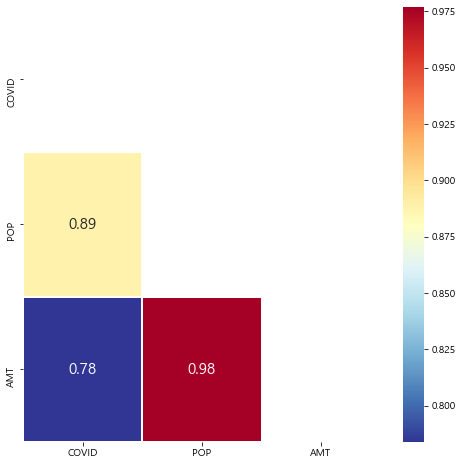

In [399]:
# 전체
corr(month_concat_all['INDEX'], sk_2020_all['SUM'], sh_2020_all['USE_AMT'])

# 문제점 
# 만든 지표는 전국에 대한 데이터 BUT SK데이터와 SH 데이터는 서울/대구를 합한 것

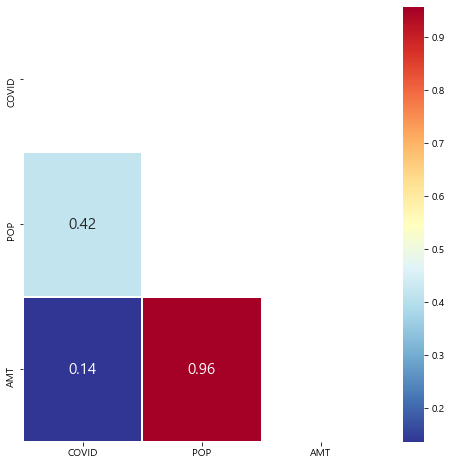

In [388]:
# 서울
corr(month_concat_seoul['INDEX'], sk_2020_seoul['SUM'], sh_2020_seoul['USE_AMT'])

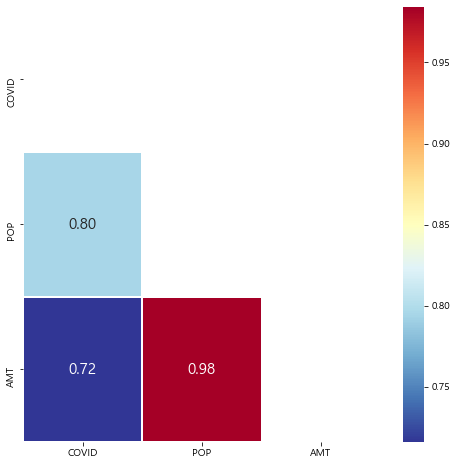

In [389]:
# 대구
corr(month_concat_daegu['INDEX'], sk_2020_daegu['SUM'], sh_2020_daegu['USE_AMT'])

### 9. 확진자수와 sk/sh 비교하기

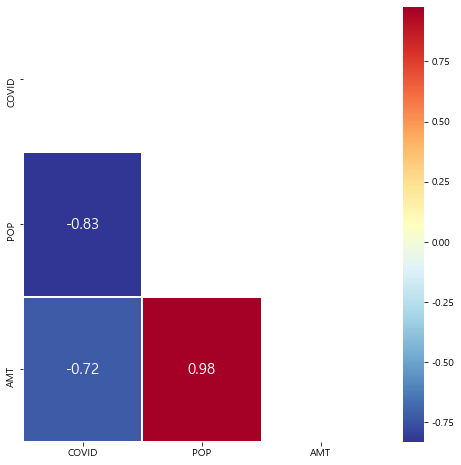

In [400]:
# 전체
corr(all_month_num['NUM'], sk_2020_all['SUM'], sh_2020_all['USE_AMT'])
# 문제점 
# 확진자수는 전국에 대한 데이터 BUT SK데이터와 SH 데이터는 서울/대구를 합한 것

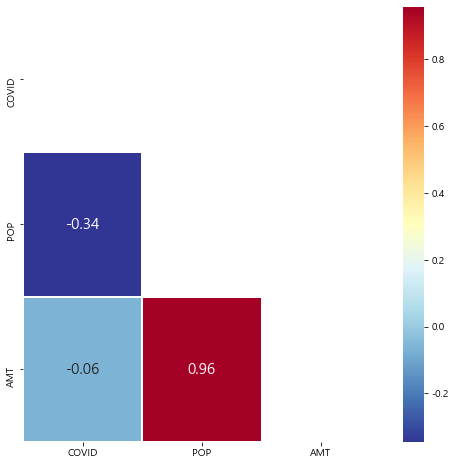

In [329]:
# 서울
corr(seoul_month_num['NUM'], sk_2020_seoul['SUM'], sh_2020_seoul['USE_AMT'])

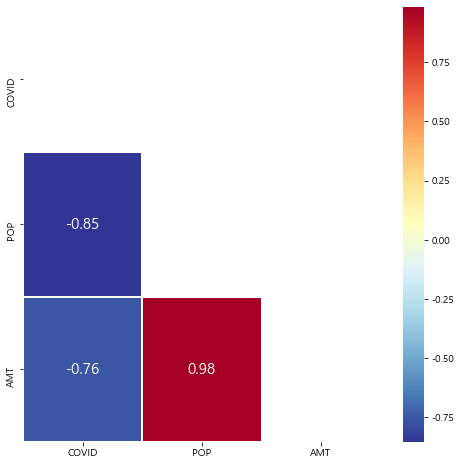

In [330]:
# 대구
corr(daegu_month_num['NUM'], sk_2020_daegu['SUM'], sh_2020_daegu['USE_AMT'])